## Keras API organized

In the previous exercise, we had to use the **rnn_layer** function during serving because we created a loop over sequences (while serving). This is a bad idea, because it makes the graph bigger unnecessarily. Now we will demonstrate a better code organization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEQ = 600
HIDDEN = 300

**Feedable iterator**

In [3]:
output_types = (tf.float32,tf.float32)
output_shapes = (tf.TensorShape((None,None)),tf.TensorShape((None,None,1)))

handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,output_types,output_shapes)
idx,y = iterator.get_next()

In [4]:
def generator():
    
    x = np.linspace(0,200,1000)
    b = np.random.uniform(-.05,.05,10)
    y = 0.5
    for i in range(1,10):
        omega = i*np.pi/20.
        y -= (0.318/i)*np.sin(omega*x) + b[i]*np.cos(omega*x)
        
    for i in range(2000):
        idx = np.random.randint(0,400) #scalar
        yield (x[idx:idx+SEQ],y[idx:idx+SEQ]) 

**Training dataset**

In [5]:
dataset = tf.data.Dataset.from_generator(generator,(tf.float32,tf.float32),((SEQ,),(SEQ,)))
dataset = dataset.map(lambda x,y:(x,tf.expand_dims(y,axis=1)))
dataset = dataset.repeat(1)
dataset = dataset.batch(1)
train_iterator = dataset.make_one_shot_iterator()

In [6]:
dataset.output_shapes

(TensorShape([Dimension(None), Dimension(600)]),
 TensorShape([Dimension(None), Dimension(600), Dimension(1)]))

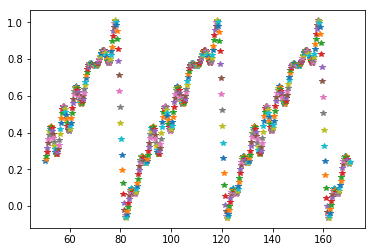

In [7]:
with tf.Session() as sess:
    hdl = sess.run(train_iterator.string_handle())
    x_,y_ = sess.run([idx,y],{handle:hdl})
    plt.plot(x_,y_.reshape(-1,SEQ),'*')

**Create the rnn**

In [8]:
target = y[:,1:]
cells = [tf.keras.layers.SimpleRNNCell(HIDDEN,activation=tf.nn.relu),tf.keras.layers.SimpleRNNCell(HIDDEN,activation=tf.nn.relu)]
#cells = tf.keras.layers.LSTMCell(HIDDEN,activation=tf.nn.relu)
rnn_layer = tf.keras.layers.RNN(cells,return_state=True,return_sequences=True,unroll=True)

**Unrolled version. We have to know the sequence size beforehand** (Do not unroll when you use LSTM for this sequence size)

In [9]:
X = y[:,:-1]
X = tf.reshape(X,(-1,SEQ-1,1))

with tf.variable_scope("RNN",reuse=tf.AUTO_REUSE):
#     H,h1_last = rnn_layer(X)
    H,h1_last,h2_last = rnn_layer(X)
with tf.variable_scope("Out",reuse=tf.AUTO_REUSE):
    outputs = tf.layers.dense(H,1)

**Give a hook for rolled version. This is used when we get random sequence size from training data**

In [10]:
#Rolled : used when we have Random sequence
X = y[:,:-1]
rnn_layer.unroll = False
with tf.variable_scope("RNN",reuse=True):
#     H_r,h1_last_r = rnn_layer(X)
    H_r,h1_last_r,h2_last_r = rnn_layer(X)
with tf.variable_scope("Out",reuse=True):
    outputs_r = tf.layers.dense(H_r,1)

**Generate version. Do not unroll INSIDE the graph for production run! you will make the graph bigger**

In [11]:
#Dynamic
rnn_layer.unroll = False
h1_initial_eval = tf.placeholder(tf.float32,(None,300))
h2_initial_eval = tf.placeholder(tf.float32,(None,300))
x_in = tf.placeholder(tf.float32,(None,None,1))
with tf.variable_scope("RNN",reuse=True):
    H_eval,h1_last_eval,h2_last_eval = rnn_layer(x_in,initial_state=[h1_initial_eval,h2_initial_eval])
with tf.variable_scope("Out",reuse=True):
    outputs_eval = tf.layers.dense(H_eval,1)

In [12]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'RNN/rnn/kernel:0' shape=(1, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias:0' shape=(300,) dtype=float32>,
 <tf.Variable 'RNN/rnn/kernel_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/recurrent_kernel_1:0' shape=(300, 300) dtype=float32>,
 <tf.Variable 'RNN/rnn/bias_1:0' shape=(300,) dtype=float32>,
 <tf.Variable 'Out/dense/kernel:0' shape=(300, 1) dtype=float32_ref>,
 <tf.Variable 'Out/dense/bias:0' shape=(1,) dtype=float32_ref>]

### Optimizer

In [13]:
loss = tf.reduce_mean(tf.square(outputs-target))
#loss = tf.reduce_mean(tf.square(outputs_r-target)) #for lstm, unrolling takes ton of time to load. and outputs nan
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)
saver = tf.train.Saver()

### Train

In [14]:
!rm models/RNN3/*

In [15]:
def train_rnn():
    import time
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        hdl = sess.run(train_iterator.string_handle())
        start = time.time()
        try:
            i = 1
            tmp = []
            while True:
                i = i+1
                l,_ = sess.run([loss,train],{handle:hdl})
                tmp.append(l)
                if i%500 == 0:
                    avg_loss = np.array(tmp).mean()
                    print("Batch: ",i,avg_loss)
                    tmp = []

        except tf.errors.OutOfRangeError:
            pass
        
        end = time.time()
        elapsed = end-start
        print("Elapsed time : ", elapsed, " s")
        saver.save(sess,'models/RNN3/my_first_model.ckpt')

In [16]:
train_rnn()

Batch:  500 0.0050868047
Batch:  1000 8.00294e-06
Batch:  1500 4.471315e-06
Batch:  2000 3.5515523e-06
Elapsed time :  180.00495076179504  s


### Evaluvate

**Eval dataset**

In [17]:
SEQ = 300
dataset_t = tf.data.Dataset.from_generator(generator,(tf.float32,tf.float32),((300,),(300,)))
dataset_t = dataset_t.map(lambda x,y:(x,tf.expand_dims(y,axis=1)))
dataset_t = dataset_t.repeat(1)
dataset_t = dataset_t.batch(1)
test_iterator = dataset_t.make_one_shot_iterator()

**Use rolled version**

INFO:tensorflow:Restoring parameters from models/RNN3/my_first_model.ckpt


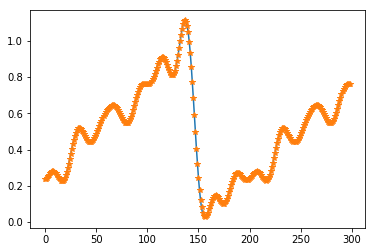

In [18]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN3/my_first_model.ckpt')   
    hdl = sess.run(test_iterator.string_handle())

    oe,t = sess.run([outputs_r,target],{handle:hdl})

    plt.plot(t[0].reshape(299))
    plt.plot(oe[0].reshape(299),'*')

**Use generate version**

INFO:tensorflow:Restoring parameters from models/RNN3/my_first_model.ckpt


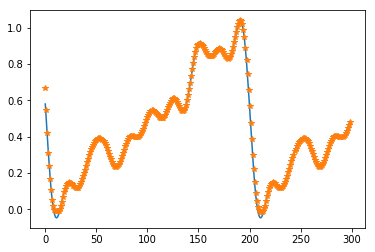

In [19]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN3/my_first_model.ckpt')   
    hdl = sess.run(test_iterator.string_handle())
    
    x_init,t = sess.run([y[:,:-1],target],{handle:hdl})
    h1_init = np.zeros((1,300))
    h2_init = np.zeros((1,300))

    oe = sess.run(outputs_eval,{h1_initial_eval:h1_init,h2_initial_eval:h2_init,x_in:x_init})

    plt.plot(t[0].reshape(299))
    plt.plot(oe[0].reshape(299),'*')

### Generation test

INFO:tensorflow:Restoring parameters from models/RNN3/my_first_model.ckpt


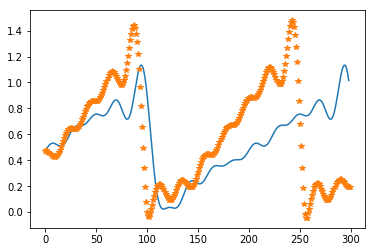

In [20]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN3/my_first_model.ckpt')   
    
    hdl = sess.run(test_iterator.string_handle())
    t = sess.run(target,{handle:hdl})

    h1_init = np.zeros((1,300))
    h2_init = np.zeros((1,300))
    x_init = np.array(t[0][0]).reshape(1,1,1).astype(np.float)
        
    out = []
    for i in range(300):
        out.append(x_init)
        x_init,h1_init,h2_init = sess.run([outputs_eval,h1_last_eval,h2_last_eval],
                                  {h1_initial_eval:h1_init,
                                   h2_initial_eval:h2_init,
                                   x_in:x_init})
        
     
    plt.plot(t[0].reshape(299))
    plt.plot(np.array(out).reshape(300),'*')

## Summary

> 1) We do not get the close enough generation all the time

>2) Do not unroll INSIDE the graph for production run! you will make the graph bigger

>3) Unrolled LSTM for this sequence size makes things slower. It also does not show the right result. (shows nan)